<a href="https://colab.research.google.com/github/hdzhao-beep/CS230-FINAL-PROJECT/blob/main/dl_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install transformers==4.28.0
!pip3 install evaluate
!pip3 install torch
!pip3 install protobuf==3.20.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69

In [2]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

import torch
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline
from datasets import Dataset
import evaluate

from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import nltk
from nltk.tokenize import RegexpTokenizer
import opendatasets as od
import string
from wordcloud import WordCloud
from distributed import Client
client = Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39069
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:32893'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35543'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44043'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46529'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:35113', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35113
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34254
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33727', name: 2, status: 

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Prepare training and test Dataset



In [82]:
def import_tweets(path):
  df1 = pd.read_csv(path,encoding='latin-1')
  df1 = df1.dropna(subset=['label'])
  df1["text"] = df1["text"].astype(str)
  df1 = df1[df1['label'] != 0.0]
  df1.loc[df1['label'] == 1.0, 'label'] = 1
  df1.loc[df1['label'] == -1.0, 'label'] = 0
  df1['label'] = df1['label'].astype(int)
  df1 = df1.head(10000)
  return df1

In [83]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_COLUMNS=['target','ids','date','flag','user','text']
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin",header=None,names=DATASET_COLUMNS)
df_test = import_tweets("test.csv")
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [85]:
dataset=df[['text','target']]
dataset['target'] = dataset['target'].replace(4,1)
dataset_test = df_test

<ipython-input-85-12bc0327d87c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset['target'].replace(4,1)


In [86]:
dataset['text']=dataset['text'].str.lower()
dataset_test['text']=dataset_test['text'].str.lower()
dataset

<ipython-input-86-d47401db6a42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']=dataset['text'].str.lower()


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,just woke up. having no school is the best fee...,1
1599996,thewdb.com - very cool to hear old walt interv...,1
1599997,are you ready for your mojo makeover? ask me f...,1
1599998,happy 38th birthday to my boo of alll time!!! ...,1


In [7]:
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [87]:
def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in set(stopwords)])
dataset['text'] = dataset['text'].apply(lambda text: clean_stopwords(text))
dataset_test['text'] = dataset_test['text'].apply(lambda text: clean_stopwords(text))
dataset.head()

<ipython-input-87-416c08d5653b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda text: clean_stopwords(text))


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,upset can't update facebook texting it... migh...,0
2,@kenichan dived many times ball. managed save ...,0
3,whole body feels itchy like fire,0
4,"@nationwideclass no, it's not behaving all. i'...",0


In [88]:
def clean_username(data):
    return re.sub('@[^\s]+',' ', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_username(x))
dataset_test['text'] = dataset_test['text'].apply(lambda x: clean_username(x))
dataset

<ipython-input-88-a2f1213d4711>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: clean_username(x))


,text,target
0,"http://twitpic.com/2y1zl - awww, that's bumm...",0
1,upset can't update facebook texting it... migh...,0
2,dived many times ball. managed save 50% rest...,0
3,whole body feels itchy like fire,0
4,"no, it's not behaving all. i'm mad. here? ca...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,thewdb.com - cool hear old walt interviews! â...,1
1599997,ready mojo makeover? ask details,1
1599998,happy 38th birthday boo alll time!!! tupac ama...,1


In [89]:
def clean_url(data):
    data=re.sub(r"((https|http|ftp)?(:\/\/)?(www\.)?)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)",' ',data)
    return re.sub(r'/', ' / ', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_url(x))
dataset_test['text'] = dataset_test['text'].apply(lambda x: clean_url(x))
dataset

<ipython-input-89-737229640593>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: clean_url(x))


,text,target
0,"- awww, that's bummer. shoulda got david c...",0
1,upset can't update facebook texting it... migh...,0
2,dived many times ball. managed save 50% rest...,0
3,whole body feels itchy like fire,0
4,"no, it's not behaving all. i'm mad. here? ca...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,- cool hear old walt interviews! â«,1
1599997,ready mojo makeover? ask details,1
1599998,happy 38th birthday boo alll time!!! tupac ama...,1


In [90]:
def clean_repeating_char(text):
    return re.sub(r"(.)\1\1+", r"\1\1", text)
dataset['text'] = dataset['text'].apply(lambda x: clean_repeating_char(x))
dataset_test['text'] = dataset_test['text'].apply(lambda x: clean_repeating_char(x))
dataset

<ipython-input-90-d65dc2d295fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: clean_repeating_char(x))


,text,target
0,"- aww, that's bummer. shoulda got david carr...",0
1,upset can't update facebook texting it.. might...,0
2,dived many times ball. managed save 50% rest...,0
3,whole body feels itchy like fire,0
4,"no, it's not behaving all. i'm mad. here? ca...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,- cool hear old walt interviews! â«,1
1599997,ready mojo makeover? ask details,1
1599998,happy 38th birthday boo all time!! tupac amaru...,1


In [91]:
def clean_emoji(data):    
    data = re.sub(r'<3', '<heart>', data)
    data = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', data)
    data = re.sub(r"[8:=;]['`\-]?\(+", '<sad>', data)
    data = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutral>', data)
    data = re.sub(r"[8:=;]['`\-]?p+", '<laugh>', data)
    return data
dataset['text'] = dataset['text'].apply(lambda x: clean_emoji(x))
dataset_test['text'] = dataset_test['text'].apply(lambda x: clean_emoji(x))
dataset

<ipython-input-91-da907014d858>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: clean_emoji(x))


,text,target
0,"- aww, that's bummer. shoulda got david carr...",0
1,upset can't update facebook texting it.. might...,0
2,dived many times ball. managed save 50% rest...,0
3,whole body feels itchy like fire,0
4,"no, it's not behaving all. i'm mad. here? ca...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,- cool hear old walt interviews! â«,1
1599997,ready mojo makeover? ask details,1
1599998,happy 38th birthday boo all time!! tupac amaru...,1


In [92]:
def clean_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_numbers(x))
dataset_test['text'] = dataset_test['text'].apply(lambda x: clean_numbers(x))
dataset

<ipython-input-92-e6a7da90220f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: clean_numbers(x))


,text,target
0,"- aww, that's bummer. shoulda got david carr...",0
1,upset can't update facebook texting it.. might...,0
2,dived many times ball. managed save % rest g...,0
3,whole body feels itchy like fire,0
4,"no, it's not behaving all. i'm mad. here? ca...",0
...,...,...
1599995,woke up. no school best feeling ever,1
1599996,- cool hear old walt interviews! â«,1
1599997,ready mojo makeover? ask details,1
1599998,happy th birthday boo all time!! tupac amaru s...,1


In [94]:
def clean_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))
dataset['text']= dataset['text'].apply(lambda x: clean_punctuations(x))
dataset_test['text']= dataset_test['text'].apply(lambda x: clean_punctuations(x))
dataset

<ipython-input-94-c827c4ac763f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: clean_punctuations(x))


,text,target
0,aww thats bummer shoulda got david carr thi...,0
1,upset cant update facebook texting it might cr...,0
2,dived many times ball managed save rest go ...,0
3,whole body feels itchy like fire,0
4,no its not behaving all im mad here cant see...,0
...,...,...
1599995,woke up no school best feeling ever,1
1599996,cool hear old walt interviews â«,1
1599997,ready mojo makeover ask details,1
1599998,happy th birthday boo all time tupac amaru shakur,1


In [95]:
def clean_nonalpha(data):
    return re.sub("[^a-z0-9<>]", ' ', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_nonalpha(x))
dataset_test['text'] = dataset_test['text'].apply(lambda x: clean_nonalpha(x))
dataset

<ipython-input-95-50fb64af2a84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: clean_nonalpha(x))


,text,target
0,aww thats bummer shoulda got david carr thi...,0
1,upset cant update facebook texting it might cr...,0
2,dived many times ball managed save rest go ...,0
3,whole body feels itchy like fire,0
4,no its not behaving all im mad here cant see...,0
...,...,...
1599995,woke up no school best feeling ever,1
1599996,cool hear old walt interviews,1
1599997,ready mojo makeover ask details,1
1599998,happy th birthday boo all time tupac amaru shakur,1


In [96]:
dataset['text'] = dataset['text'].apply(RegexpTokenizer(r'\w+').tokenize)
dataset_test['text'] = dataset_test['text'].apply(RegexpTokenizer(r'\w+').tokenize)
dataset

<ipython-input-96-73cf4509b695>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(RegexpTokenizer(r'\w+').tokenize)


,text,target
0,"[aww, thats, bummer, shoulda, got, david, carr...",0
1,"[upset, cant, update, facebook, texting, it, m...",0
2,"[dived, many, times, ball, managed, save, rest...",0
3,"[whole, body, feels, itchy, like, fire]",0
4,"[no, its, not, behaving, all, im, mad, here, c...",0
...,...,...
1599995,"[woke, up, no, school, best, feeling, ever]",1
1599996,"[cool, hear, old, walt, interviews]",1
1599997,"[ready, mojo, makeover, ask, details]",1
1599998,"[happy, th, birthday, boo, all, time, tupac, a...",1


In [97]:
def stem_text(data):
    return [nltk.stem.snowball.SnowballStemmer(language='english').stem(word) for word in data]
dataset['text']= dataset['text'].apply(lambda x: stem_text(x))
dataset_test['text']= dataset_test['text'].apply(lambda x: stem_text(x))
dataset

<ipython-input-97-32dbff6daddb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: stem_text(x))


,text,target
0,"[aww, that, bummer, shoulda, got, david, carr,...",0
1,"[upset, cant, updat, facebook, text, it, might...",0
2,"[dive, mani, time, ball, manag, save, rest, go...",0
3,"[whole, bodi, feel, itchi, like, fire]",0
4,"[no, it, not, behav, all, im, mad, here, cant,...",0
...,...,...
1599995,"[woke, up, no, school, best, feel, ever]",1
1599996,"[cool, hear, old, walt, interview]",1
1599997,"[readi, mojo, makeov, ask, detail]",1
1599998,"[happi, th, birthday, boo, all, time, tupac, a...",1


In [99]:
def lemmatize_text(data):
    return [WordNetLemmatizer().lemmatize(word) for word in data]
dataset['text'] = dataset['text'].apply(lambda x: lemmatize_text(x))
dataset_test['text'] = dataset_test['text'].apply(lambda x: lemmatize_text(x))
dataset

<ipython-input-99-a558a953ca13>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: lemmatize_text(x))


,text,target
0,"[aww, that, bummer, shoulda, got, david, carr,...",0
1,"[upset, cant, updat, facebook, text, it, might...",0
2,"[dive, mani, time, ball, manag, save, rest, go...",0
3,"[whole, bodi, feel, itchi, like, fire]",0
4,"[no, it, not, behav, all, im, mad, here, cant,...",0
...,...,...
1599995,"[woke, up, no, school, best, feel, ever]",1
1599996,"[cool, hear, old, walt, interview]",1
1599997,"[readi, mojo, makeov, ask, detail]",1
1599998,"[happi, th, birthday, boo, all, time, tupac, a...",1


In [102]:
X=dataset.text
y=dataset.target
X_test = dataset_test.text
y_test = dataset_test.label

In [103]:
X=X.apply(lambda x: " ".join(x))
X_test=X_test.apply(lambda x: " ".join(x))

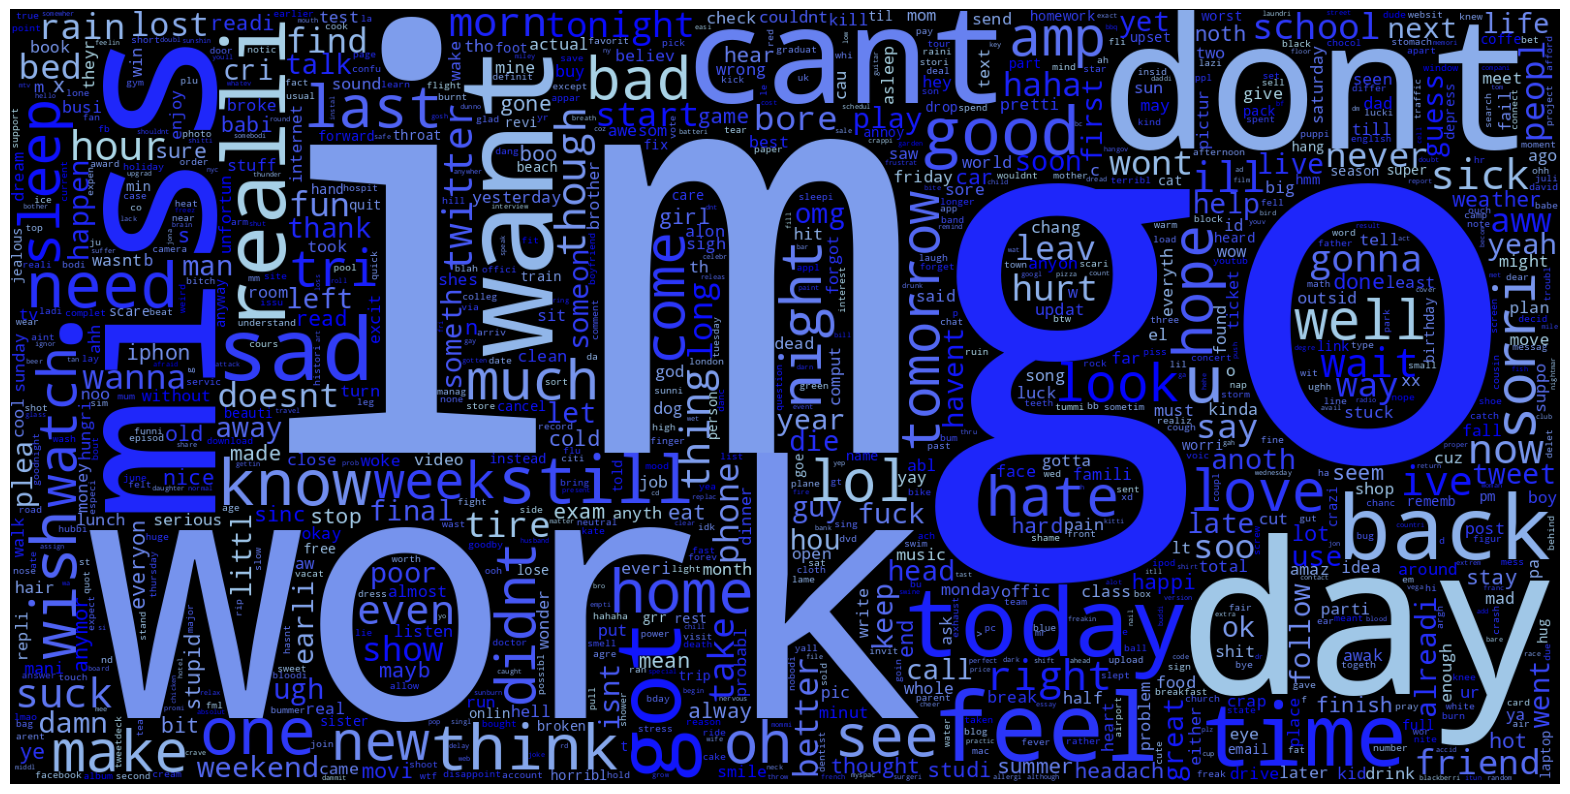

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import colors

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    gradient = colors.LinearSegmentedColormap.from_list('blue_gradient', ['#0000FF', '#ADD8E6'])
    return tuple(int(x * 255) for x in gradient(random_state.randint(0, 255)))

data_neg = dataset[dataset.target==0].text
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False, color_func=color_func).generate(" ".join(" ".join(i) for i in data_neg))
plt.imshow(wc)
plt.axis('off')
plt.show()


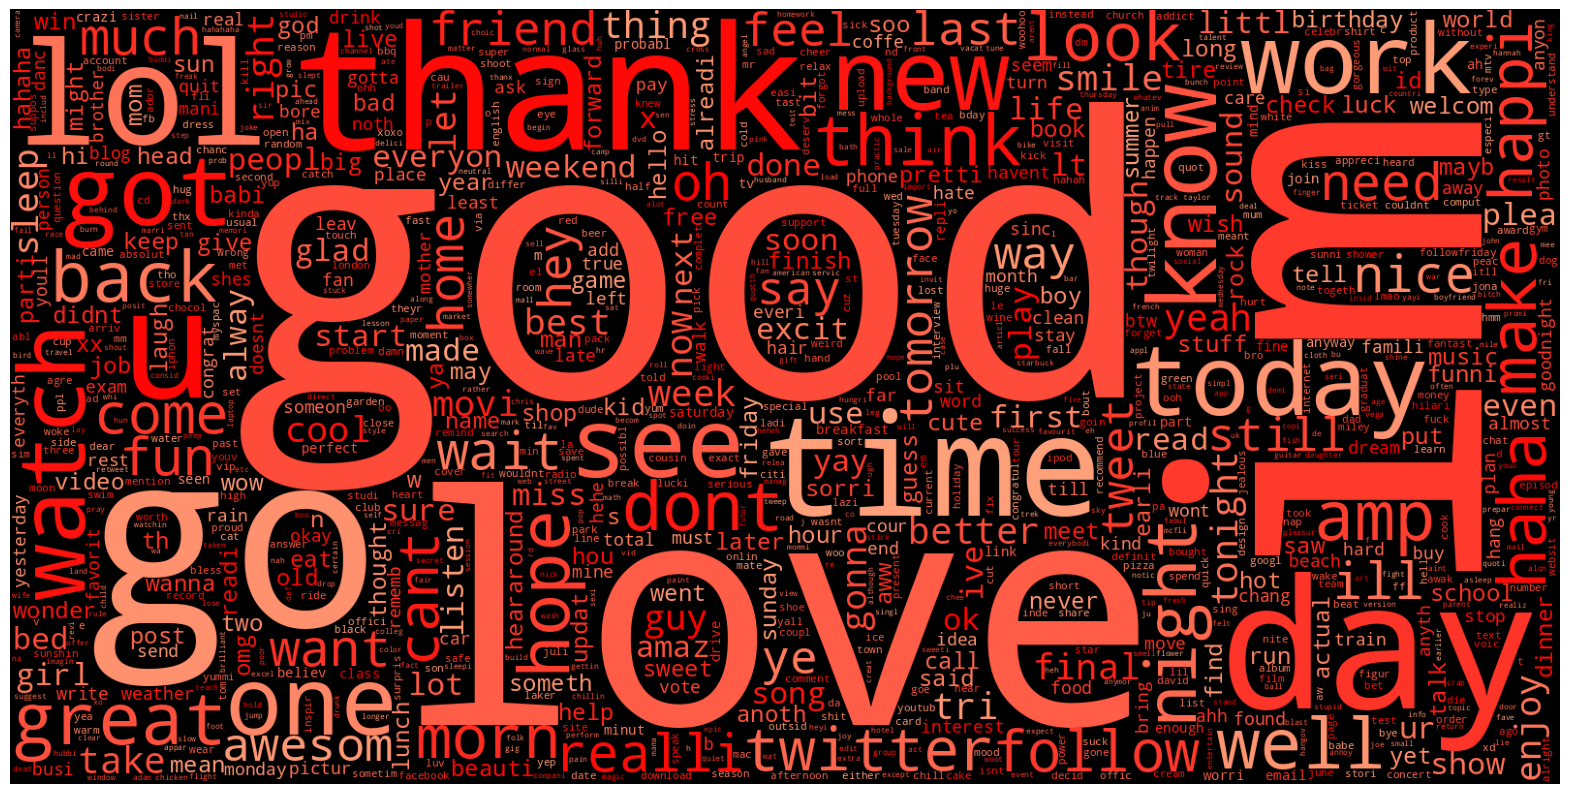

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import colors

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    gradient = colors.LinearSegmentedColormap.from_list('red_gradient', ['#FF0000', '#FFA07A'])
    return tuple(int(x * 255) for x in gradient(random_state.randint(0, 255)))

data_neg = dataset[dataset.target == 1].text
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False, color_func=color_func).generate(" ".join(" ".join(i) for i in data_neg))
plt.imshow(wc)
plt.axis('off')
plt.show()


In [104]:
X_train = X
y_train = y

In [106]:
df_train = pd.concat([X, y], axis=1)
df_train.columns = ['text', 'label']
df_test = pd.concat([X_test, y_test], axis=1)
df_test.columns = ['text', 'label']
print(df_train)

                                                      text  label
0        aww that bummer shoulda got david carr third d...      0
1        upset cant updat facebook text it might cri re...      0
2             dive mani time ball manag save rest go bound      0
3                          whole bodi feel itchi like fire      0
4        no it not behav all im mad here cant see over ...      0
...                                                    ...    ...
1599995                   woke up no school best feel ever      1
1599996                       cool hear old walt interview      1
1599997                       readi mojo makeov ask detail      1
1599998  happi th birthday boo all time tupac amaru shakur      1
1599999                               happi charitytuesday      1

[1600000 rows x 2 columns]


Basic BERT

In [50]:
class TwitterSentimentClassifier():
    
    def __init__(self, model_name='bert-base-uncased', num_labels=2):
        self.model_name = model_name
        self.num_labels = num_labels
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        
        self.metric_accuracy = evaluate.load("accuracy")
        self.metric_precision = evaluate.load("precision")
        self.metric_recall = evaluate.load("recall")   
        
    def tokenize_function(self, batch):
        tokenized_batch = self.tokenizer(batch["text"], padding='max_length', truncation=True, max_length=125)
        tokenized_batch["label"] = batch["label"]
        return tokenized_batch
    
    def import_tweets(self, data):
        self.train, self.test = train_test_split(data, train_size = 50000,test_size = 5000, random_state =2018012198)
        
        self.train = Dataset.from_pandas(self.train)
        self.test =  Dataset.from_pandas(self.test)
        
        self.train_dataset = self.train.map(self.tokenize_function, batched=True)
        self.test_dataset = self.test.map(self.tokenize_function, batched=True)
        
    def get_metrics(self, predictions, labels):
        accuracy = self.metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
        precision = self.metric_precision.compute(predictions=predictions, references=labels)["precision"]
        recall = self.metric_recall.compute(predictions=predictions, references=labels)["recall"]
        f1_score = 2 * (precision * recall) / (precision + recall)

        return {"accuracy":accuracy,
                "precision":precision,
                "recall":recall,
                "f1": f1_score}
        
    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        return self.get_metrics(predictions, labels)

    def train_model(self):
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels).to(self.device)
        self.training_args = TrainingArguments(
            output_dir="training_arguments", 
            evaluation_strategy="epoch",
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            learning_rate=3e-5,
            weight_decay=0.01,
            num_train_epochs=3,
        )
        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.test_dataset,
            compute_metrics=self.compute_metrics,
        )
        
        self.trainer.train()
        self.model = self.model.to("cpu")
        
    def save_model_local(self, path):
        self.trainer.save_model(path)
            
    def load_saved_model(self, path):
        self.model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=self.num_labels)
        self.model = self.model.to("cpu")
        self.pipe = TextClassificationPipeline(model=self.model, tokenizer=self.tokenizer)
        
    def get_scores(self, text):
        return self.pipe(text)
    
    def predict(self, text):
        label2id = {"LABEL_0":0, "LABEL_1":1}
        scores = self.get_scores(text)
        predicted = [label2id[sample["label"]] for sample in scores]
        return predicted
    def evaluate_model(self,df_test):        
        self.eval = Dataset.from_pandas(df_test)
        self.eval_dataset = self.eval.map(self.tokenize_function, batched=True) 
        predictions = np.array(self.predict(self.eval_dataset["text"]))
        labels = np.array(self.eval_dataset["label"])
        return self.get_metrics(predictions, labels)       

In [51]:
ts = TwitterSentimentClassifier()

In [25]:
ts.import_tweets(df_train)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [26]:
ts.train_model()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.463100,0.450096,0.789600,0.798142,0.767045,0.782285
2,0.357300,0.475145,0.789400,0.789733,0.780438,0.785058
3,0.254400,0.550548,0.788800,0.789951,0.778409,0.784137


In [27]:
ts.save_model_local("twitter-sentiment-500k-2e")

In [52]:
ts.load_saved_model("twitter-sentiment-500k-2e")

In [107]:
ts.evaluate_model(df_test)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'accuracy': 0.6267,
 'precision': 0.793800539083558,
 'recall': 0.5566230902504331,
 'f1': 0.6543838533469123}

New Bert

In [76]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
class FIN_twitterSentimentClassifier():
    
    def __init__(self, model_name='distilbert-base-uncased', num_labels=2):
        self.model_name = model_name
        self.num_labels = num_labels
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.tokenizer = DistilBertTokenizer.from_pretrained(self.model_name)
        
        self.metric_accuracy = evaluate.load("accuracy")
        self.metric_precision = evaluate.load("precision")
        self.metric_recall = evaluate.load("recall")   
        
    def tokenize_function(self, batch):
        tokenized_batch = self.tokenizer(batch["text"], padding='max_length', truncation=True, max_length=125)
        tokenized_batch["label"] = batch["label"]
        return tokenized_batch
    
    def import_tweets(self, data):
        self.train, self.test = train_test_split(data, train_size = 200000,test_size = 5000, random_state =2018012198)
        
        self.train = Dataset.from_pandas(self.train)
        self.test =  Dataset.from_pandas(self.test)
        
        self.train_dataset = self.train.map(self.tokenize_function, batched=True)
        self.test_dataset = self.test.map(self.tokenize_function, batched=True)
        
    def get_metrics(self, predictions, labels):
        accuracy = self.metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
        precision = self.metric_precision.compute(predictions=predictions, references=labels)["precision"]
        recall = self.metric_recall.compute(predictions=predictions, references=labels)["recall"]
        f1_score = 2 * (precision * recall) / (precision + recall)

        return {"accuracy":accuracy,
                "precision":precision,
                "recall":recall,
                "f1": f1_score}
        
    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        return self.get_metrics(predictions, labels)

    def train_model(self):
        self.model = DistilBertForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels).to(self.device)
        self.training_args = TrainingArguments(
            output_dir="training_arguments", 
            evaluation_strategy="epoch",
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            learning_rate=3e-5,
            weight_decay=0.01,
            num_train_epochs=3,
        )
        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.test_dataset,
            compute_metrics=self.compute_metrics,
        )
        
        self.trainer.train()
        self.model = self.model.to("cpu")
        
    def save_model_local(self, path):
        self.trainer.save_model(path)
            
    def load_saved_model(self, path):
        self.model = DistilBertForSequenceClassification.from_pretrained(path, num_labels=self.num_labels)
        self.model = self.model.to("cpu")
        self.pipe = TextClassificationPipeline(model=self.model, tokenizer=self.tokenizer)
        
    def get_scores(self, text):
        return self.pipe(text)
    
    def predict(self, text):
        label2id = {"LABEL_0":0, "LABEL_1":1}
        scores = self.get_scores(text)
        predicted = [label2id[sample["label"]] for sample in scores]
        return predicted
    def evaluate_model(self,df_test):        
        self.eval = Dataset.from_pandas(df_test)
        self.eval_dataset = self.eval.map(self.tokenize_function, batched=True) 
        predictions = np.array(self.predict(self.eval_dataset["text"]))
        labels = np.array(self.eval_dataset["label"])
        return self.get_metrics(predictions, labels)       

In [77]:
ts_new = FIN_twitterSentimentClassifier()
ts_new.import_tweets(df_train)
ts_new.train_model()

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

INFO:distributed.utils_perf:full garbage collection released 142.54 MiB from 2499 reference cycles (threshold: 9.54 MiB)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.428800,0.426049,0.803000,0.785632,0.825487,0.805066
2,0.367200,0.424405,0.811800,0.827527,0.780844,0.803508
3,0.290900,0.466315,0.809600,0.813173,0.796672,0.804838


In [ ]:
ts_new.save_model_local("new_model")
ts_new.load_saved_model("new_model")
ts_new.evaluate_model(df_test)

WORD2VEC

In [109]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

INFO:distributed.utils_perf:full garbage collection released 139.93 MiB from 2283 reference cycles (threshold: 9.54 MiB)


In [110]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 40660
CPU times: user 2min 29s, sys: 797 ms, total: 2min 29s
Wall time: 35.5 s


In [111]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [112]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [113]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1600000, 60)
X_test.shape : (10000, 60)


In [114]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


BiLSTM

In [115]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [116]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [117]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

In [118]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [119]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
1407/1407 [==============================] - 52s 27ms/step - loss: 0.4515 - accuracy: 0.7861 - val_loss: 0.4459 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - 36s 25ms/step - loss: 0.4217 - accuracy: 0.8045 - val_loss: 0.4892 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - 36s 26ms/step - loss: 0.4123 - accuracy: 0.8096 - val_loss: 0.4799 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/10
1407/1407 [==============================] - 36s 26ms/step - loss: 0.4066 - accuracy: 0.8127 - val_loss: 0.4973 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 5/10
1407/1407 [==============================] - 36s 26ms/step - loss: 0.4021 - accuracy: 0.8151 - val_loss: 0.4491 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 6/10
1407/1407 [==============================] - 36s 26ms/step - loss: 0.3986 - accuracy: 0.8173 - val_loss: 0.5064 - val_accuracy: 0.7633 - lr: 0.0010


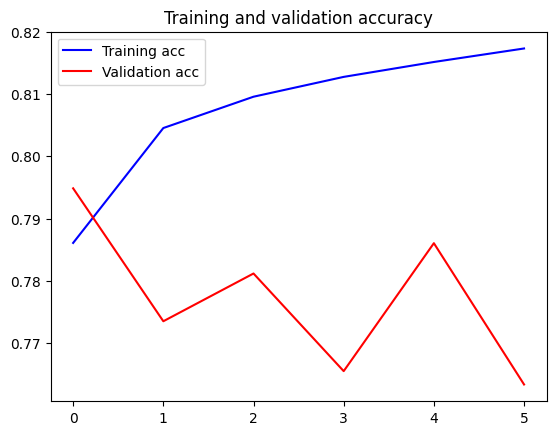

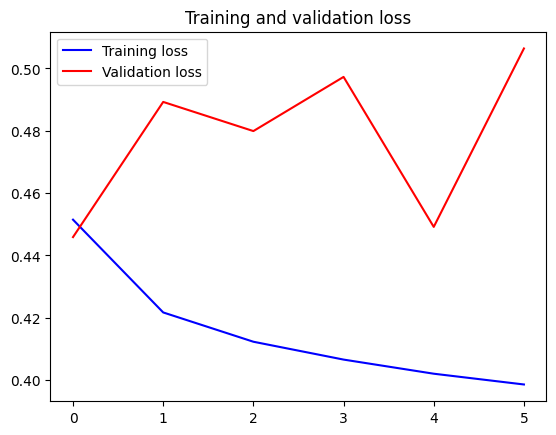

In [120]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

313/313 [==============================] - 3s 5ms/step
Accuracy: 0.6389
Precision: 0.816458622283865
Recall: 0.5563080800126005
F1-score: 0.6617330210772835


TEXT CNN

In [122]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Sequential

def getModel2():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    num_filters = 128
    kernel_sizes = [3, 4, 5]
    dropout_rate = 0.5

    model = Sequential()
    model.add(embedding_layer)

    # CNN layers
    for kernel_size in kernel_sizes:
        model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
        
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [123]:
training_model2 = getModel2()
training_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 58, 128)           38528     
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 128)           65664     
                                                                 
 conv1d_3 (Conv1D)           (None, 51, 128)           82048     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [124]:
training_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = training_model2.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
1407/1407 [==============================] - 11s 6ms/step - loss: 0.4658 - accuracy: 0.7798 - val_loss: 0.5082 - val_accuracy: 0.7153 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.4301 - accuracy: 0.8027 - val_loss: 0.5186 - val_accuracy: 0.7251 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.4198 - accuracy: 0.8083 - val_loss: 0.5478 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.4135 - accuracy: 0.8118 - val_loss: 0.5270 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.4085 - accuracy: 0.8144 - val_loss: 0.4810 - val_accuracy: 0.7468 - lr: 0.0010
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.4041 - accuracy: 0.8170 - val_loss: 0.4953 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 7/10
1407/1407 [==============================] - 8

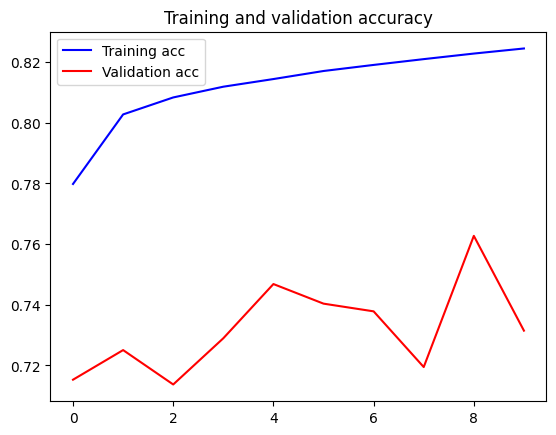

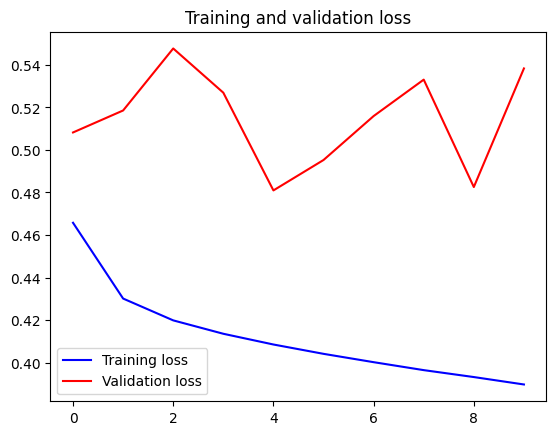

In [125]:
acc,  val_acc  = history2.history['accuracy'], history2.history['val_accuracy']
loss, val_loss = history2.history['loss'], history2.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [126]:
# Predicting on the Test dataset.
y_pred = training_model2.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.5963
Precision: 0.8136190992946283
Recall: 0.47235785163017796
F1-score: 0.5977080219232686


Simple RNN

In [127]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Sequential

def getModel3():
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    rnn_units = 128
    dropout_rate = 0.5

    model = Sequential()
    model.add(embedding_layer)
    model.add(SimpleRNN(units=rnn_units, dropout=dropout_rate,return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [128]:
training_model3 = getModel3()
training_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 60, 128)           29312     
                                                                 
 dense_4 (Dense)             (None, 60, 1)             129       
                                                                 
Total params: 6,029,441
Trainable params: 29,441
Non-trainable params: 6,000,000
_________________________________________________________________


In [129]:
training_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3 = training_model3.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
1407/1407 [==============================] - 64s 44ms/step - loss: 0.6806 - accuracy: 0.5642 - val_loss: 0.7867 - val_accuracy: 0.0782 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - 60s 43ms/step - loss: 0.6772 - accuracy: 0.5677 - val_loss: 0.7934 - val_accuracy: 0.0711 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - 61s 43ms/step - loss: 0.6759 - accuracy: 0.5688 - val_loss: 0.7918 - val_accuracy: 0.0711 - lr: 0.0010
Epoch 4/10
1407/1407 [==============================] - 62s 44ms/step - loss: 0.6758 - accuracy: 0.5687 - val_loss: 0.7998 - val_accuracy: 0.0738 - lr: 0.0010
Epoch 5/10
1407/1407 [==============================] - 61s 43ms/step - loss: 0.6758 - accuracy: 0.5689 - val_loss: 0.7910 - val_accuracy: 0.0764 - lr: 0.0010
Epoch 6/10
1407/1407 [==============================] - 61s 43ms/step - loss: 0.6752 - accuracy: 0.5694 - val_loss: 0.7916 - val_accuracy: 0.0697 - lr: 0.0010


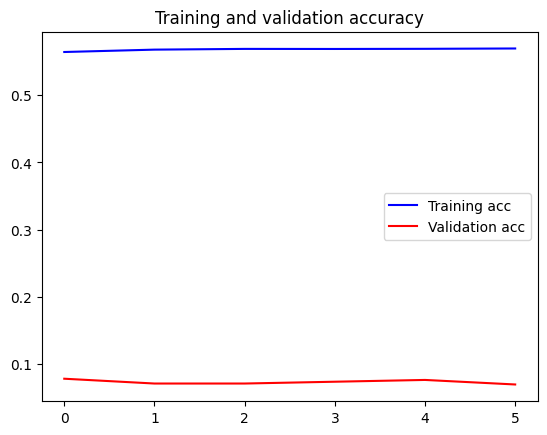

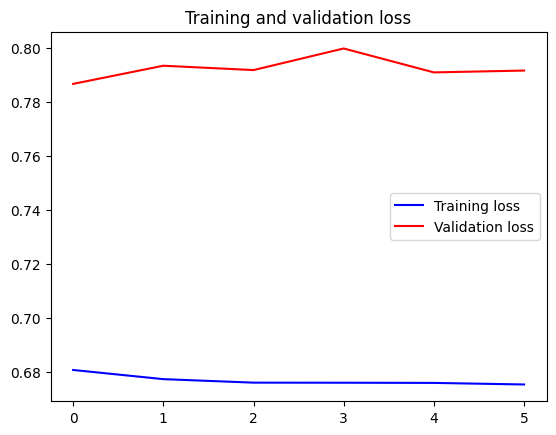

In [130]:
acc,  val_acc  = history3.history['accuracy'], history3.history['val_accuracy']
loss, val_loss = history3.history['loss'], history3.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predicting on the Test dataset.
y_pred = training_model3.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Conv LSTM

In [136]:
def getModel4():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(Conv1D(64,5,activation='relu'))
    model.add(Bidirectional(LSTM(64,return_sequences=True)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [137]:
training_model4 = getModel4()
training_model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 56, 64)            32064     
                                                                 
 bidirectional_2 (Bidirectio  (None, 56, 128)          66048     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 56, 512)           66048     
                                                                 
 dropout_3 (Dropout)         (None, 56, 512)           0         
                                                      

In [138]:
training_model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history4 = training_model4.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
1407/1407 [==============================] - 27s 16ms/step - loss: 0.4693 - accuracy: 0.7755 - val_loss: 0.5116 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - 21s 15ms/step - loss: 0.4379 - accuracy: 0.7952 - val_loss: 0.4721 - val_accuracy: 0.7744 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - 21s 15ms/step - loss: 0.4291 - accuracy: 0.8001 - val_loss: 0.4836 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 4/10
1407/1407 [==============================] - 21s 15ms/step - loss: 0.4236 - accuracy: 0.8034 - val_loss: 0.4831 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 5/10
1407/1407 [==============================] - 21s 15ms/step - loss: 0.4198 - accuracy: 0.8056 - val_loss: 0.4850 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 6/10
1407/1407 [==============================] - 21s 15ms/step - loss: 0.4167 - accuracy: 0.8073 - val_loss: 0.4450 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 7/10
1407/1407 [========================

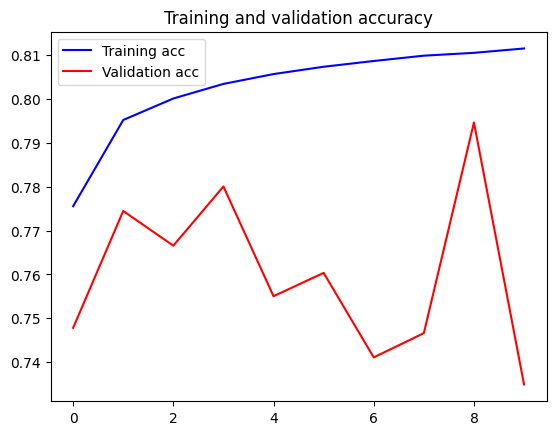

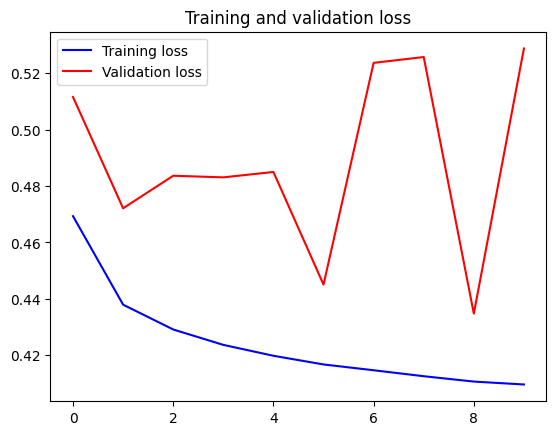

In [139]:
acc,  val_acc  = history4.history['accuracy'], history4.history['val_accuracy']
loss, val_loss = history4.history['loss'], history4.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predicting on the Test dataset.
y_pred = training_model4.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)